In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
from sqlalchemy import MetaData
import numpy as np
import pandas as pd
import csv
from collections import defaultdict
import re
import statsmodels.api as sm
from patsy import dmatrices
from sklearn.cross_validation import train_test_split
from __future__ import division
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns
from sqlalchemy import MetaData
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
import settings
import time
import glob
import pickle

In [2]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
from sklearn import preprocessing 
import xgboost
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV

## Load working df into memory for use

In [138]:
#Get Feature Types into dictionary
#0 = ignore
#1 = numerical time series
#2 = purely categorical
#3 = numerical already
#4 = categorical time series
#5 = hold onto for now, drop when want to do model
import csv
featuretype_dict = {}
typefeature_dict = defaultdict(list)
reader = csv.reader(open('../TextFiles/feature_types.csv', 'r'))
d = {}
for k,v in reader:
    featuretype_dict[k] = int(v)
    typefeature_dict[int(v)].append(k)

In [139]:
#hours_out_list = [24, 36, 48, 60, 72]
#for hours_out in hours_out_list:
hours_out = 24
model_transformed_df = pd.read_pickle('../Pickles/' + str(hours_out) + '_out_model_df.p')

In [140]:
#model_transformed_df.to_csv("all_features_dates_and_predictions.csv")

In [141]:
# model_transformed_df.merge()

#### Removing time series service type and adding admission service type

In [142]:
service_cols = [col for col in model_transformed_df.columns if 'Service Type' in col]
model_transformed_df = model_transformed_df.drop(service_cols, axis = 1)
scatter_df = pd.read_csv("../TextFiles/scatter_df.csv")
model_transformed_df = model_transformed_df.merge(scatter_df[['icustay_id', 'first_careunit']], on = 'icustay_id')

model_transformed_df = pd.get_dummies(model_transformed_df, columns = ['first_careunit'])
len(model_transformed_df.columns)

297

In [143]:
modelable_df = model_transformed_df.drop(list(typefeature_dict[5]), axis = 1)
model_column_names = list(modelable_df.columns)
model_column_names = [x.replace('<', "_LESS_") for x in model_column_names]
model_column_names = [x.replace('[', "") for x in model_column_names]
model_column_names = [x.replace(']', "") for x in model_column_names]
modelable_df.columns = model_column_names

In [81]:
X = modelable_df.drop(['hospital_expire_flag'], axis = 1)
y = modelable_df['hospital_expire_flag']

In [82]:
#X_norm = X.apply(lambda x: (x - x.mean())/x.std(ddof=0), axis = 0)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                   test_size = 0.30)

#### Create df for scatter plot

In [12]:
services_df = pd.read_pickle("../Pickles/services.p")
scatter_test_df = X_test[['age', 'icustay_id', 'los_icu']]
scatter_test_df['hospital_expire_flag'] = y_test
scatter_test_df = scatter_test_df.merge(services_df, on = 'icustay_id')
scatter_test_df = scatter_test_df.round(decimals = 2)

/home/cynthia/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [13]:
X_test_ids = list(X_test.icustay_id)
X_train_ids = list(X_train.icustay_id)

In [14]:
X_test = X_test.drop(['icustay_id'], axis = 1)
X_train = X_train.drop(['icustay_id'], axis = 1)

X = X.drop(['icustay_id'], axis = 1)

## Grid Search for XGB

In [399]:
params = {"max_depth" : [5], 
          'n_estimators': [1000, 2000], 
          'learning_rate': [0.01, 0.025, 0.05, 0.1, 0.2],
           'min_child_weight': [1]}

In [400]:
grid_xgb = GridSearchCV(xgboost.XGBClassifier(), param_grid = params, n_jobs = -1, scoring = 'f1', verbose = 2)

In [276]:
grid_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=1000, learning_rate=0.01, max_depth=5, min_child_weight=1 
[CV] n_estimators=1000, learning_rate=0.01, max_depth=5, min_child_weight=1 
[CV] n_estimators=1000, learning_rate=0.01, max_depth=5, min_child_weight=1 
[CV] n_estimators=2000, learning_rate=0.01, max_depth=5, min_child_weight=1 
[CV] n_estimators=2000, learning_rate=0.01, max_depth=5, min_child_weight=1 
[CV] n_estimators=2000, learning_rate=0.01, max_depth=5, min_child_weight=1 
[CV] n_estimators=1000, learning_rate=0.025, max_depth=5, min_child_weight=1 
[CV] n_estimators=1000, learning_rate=0.025, max_depth=5, min_child_weight=1 
[CV] n_estimators=1000, learning_rate=0.025, max_depth=5, min_child_weight=1 
[CV] n_estimators=2000, learning_rate=0.025, max_depth=5, min_child_weight=1 
[CV] n_estimators=2000, learning_rate=0.025, max_depth=5, min_child_weight=1 
[CV] n_estimators=2000, learning_rate=0.025, max_depth=5, min_child_weight=1 
[CV] n_es

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  8.4min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [1000, 2000], 'learning_rate': [0.01, 0.025, 0.05, 0.1, 0.2], 'max_depth': [5], 'min_child_weight': [1]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=2)

In [277]:
print grid_xgb.best_score_
grid_xgb.best_params_

0.790321913239


{'learning_rate': 0.2,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 2000}

In [306]:
# # grid_xgb_auc = GridSearchCV(xgboost.XGBClassifier(), param_grid = params, n_jobs = -1, scoring = 'roc_auc', verbose = 2)

# grid_xgb_auc.fit(X_train, y_train)

# print grid_xgb_auc.best_score_
# grid_xgb_auc.best_params_

In [ ]:
# grid_xgb_precision = GridSearchCV(xgboost.XGBClassifier(), param_grid = params, n_jobs = -1, scoring = 'precision', verbose = 2)

# grid_xgb_precision.fit(X_train, y_train)

# print grid_xgb_precision.best_score_
# grid_xgb_precision.best_params_

## Define and Run All Models

In [89]:
models = [#{'name': "GaussianNB", 'model': GaussianNB()},
          #{'name': "SVM", 'model': SVC(probability = True)}, 
          #{'name':"DecisionTree", 'model': DecisionTreeClassifier()}, 
          {'name':"RandomForest", 'model': RandomForestClassifier(n_estimators = 100,
                                                                 #max_depth = 5, 
                                                                 #oob_score = True, 
                                                                 n_jobs = -1,
                                                                 #class_weight = 'balanced'
                                                                 )},
          {'name': "XGBoosting", 'model': xgboost.XGBClassifier(max_depth = 5,
#                                                         n_estimators = 100,
                                                         n_estimators = 1000, 
                                                         learning_rate = 0.05,                                                    
#                                                        learning_rate = 0.2, 
                                                         min_child_weight = 1,
#                                                        min_child_weight = 5,
                                                        silent = False)},
          #{'name':"KNearest", 'model': KNeighborsClassifier(3)},
          {'name':"LogisticRegression", 'model': LogisticRegression(class_weight = 'balanced')}
         ]

In [90]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='median', axis=0)

In [91]:
for model in models:
    if model['name'] == 'XGBoosting':
        model['model'].fit(X_train, y_train)
        model['y_pred'] = model['model'].predict(X_test)
        model['y_proba'] = model['model'].predict_proba(X_test)[:, 1]
        model['y_proba_ALL'] = model['model'].predict_proba(X)[:, 1]
        model['pr_ALL'] = precision_recall_curve(y, model['y_proba_ALL'])
        model['score'] = model['model'].score(X_test, y_test) 
        #allen_df = scatter_df.copy()
        #allen_df = allen_df[['Prob_Mortality', 'first_careunit', 'icustay_id']]
        #allen_df['Prob_Mortality'] = model['y_proba_ALL']
        ###allen_df.head()
#         scatter_test_df = X_test[['age', 'los_icu', 'hospital_expire_flag']]
#         scatter_test_df['Prob_Mortality'] = 
#         #scatter_df = scatter_df.round(decimals = 2)
        #scatter_df = scatter_df.dropna()
        #scatter_df.Prob_Mortality = model['y_proba_ALL'] 
        #scatter_test_df = scatter_df[scatter_df.icustay_id.isin(X_test_ids)]
        #allen_df.to_pickle('../Pickles/allen_df.p')
        #scatter_test_df.to_csv('../TextFiles/scatter_test_df.csv')
        
    else:
        imp_X_train = imp.fit_transform(X_train)
        imp_X_test = imp.transform(X_test)
        model['model'].fit(imp_X_train, y_train)
        model['y_pred'] = model['model'].predict(imp_X_test)
        model['y_proba'] = model['model'].predict_proba(imp_X_test)[:, 1]
        model['score'] = model['model'].score(imp_X_test, y_test) 
    
    model['pr'] = precision_recall_curve(y_test, model['y_proba'])
    model['auc'] = roc_auc_score(y_test, model['y_proba'])
    model['roc'] = roc_curve(y_test, model['y_proba'])
    model['accuracy'] = accuracy_score(y_test, model['y_pred'])
    model['precision'] = precision_score(y_test, model['y_pred'])
    model['recall'] = recall_score(y_test, model['y_pred'])
    model['f1'] = f1_score(y_test, model['y_pred'])
    print "For the %s model: " %model['name']
    print "The accuracy is: %0.4f" %model['accuracy']
    print "The precision is: %0.4f" %model['precision']
    print "The recall is: %0.4f" %model['recall']
    print "The f1 score is: %0.4f" %model['f1']
    print "The SCORE is: %0.4f" %model['score']
    print

For the RandomForest model: 
The accuracy is: 0.9125
The precision is: 0.8720
The recall is: 0.6362
The f1 score is: 0.7357
The SCORE is: 0.9125

For the XGBoosting model: 
The accuracy is: 0.9287
The precision is: 0.8773
The recall is: 0.7295
The f1 score is: 0.7966
The SCORE is: 0.9287

For the LogisticRegression model: 
The accuracy is: 0.8634
The precision is: 0.6083
The recall is: 0.8027
The f1 score is: 0.6921
The SCORE is: 0.8634



#### Add probability to scatter df

In [35]:
scatter_test_df['Prob_Mortality'] = models[1]['y_proba']
scatter_test_df = scatter_test_df.round(2)
scatter_test_df = scatter_test_df.dropna()
scatter_test_df.to_csv('../TextFiles/scatter_test_df.csv')

### Add LogReg/XGB ensemble

In [36]:
# models.append({'name':"Ensemble - Logistic Regression/XGBoost"})
# models[3]['y_proba'] = np.sqrt(models[1]['y_proba']*models[2]['y_proba'])
# models[3]['pr'] = precision_recall_curve(y_test, models[3]['y_proba'])
# models[3]['auc'] = roc_auc_score(y_test, models[3]['y_proba'])
# models[3]['roc'] = roc_curve(y_test, models[3]['y_proba'])
    

## ROC curves

The AUC for RandomForest is 0.9440
The AUC for XGBoosting is 0.9564
The AUC for LogisticRegression is 0.9308


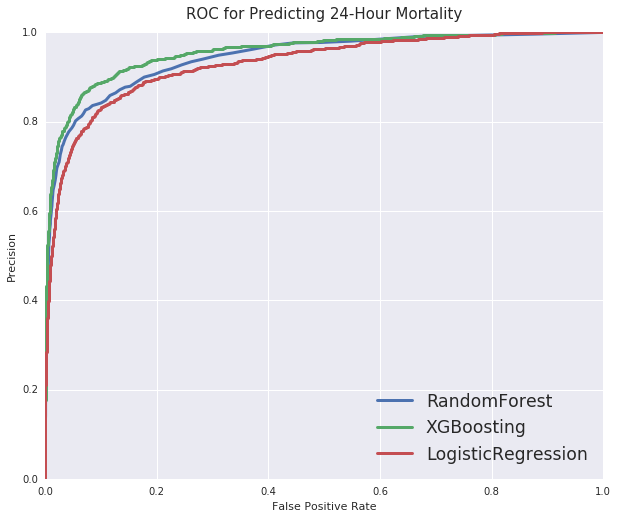

In [37]:
f, ax = plt.subplots(1, 1, figsize = (10, 8))
#f.subplots_adjust(hspace=.5)
ttl = ax.set_title('ROC for Predicting 24-Hour Mortality', fontdict = {'fontsize': 15})
ttl.set_position([.5, 1.02])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('Precision')
    
for i, model in enumerate(models):
    ax.plot(model['roc'][0],model['roc'][1], linewidth = 3, label = model['name']) 
    print "The AUC for %s is %0.4f" %(model['name'], model['auc'])

ax.legend(loc = 4, fontsize = 'x-large')    
f.show()

## PR Curves

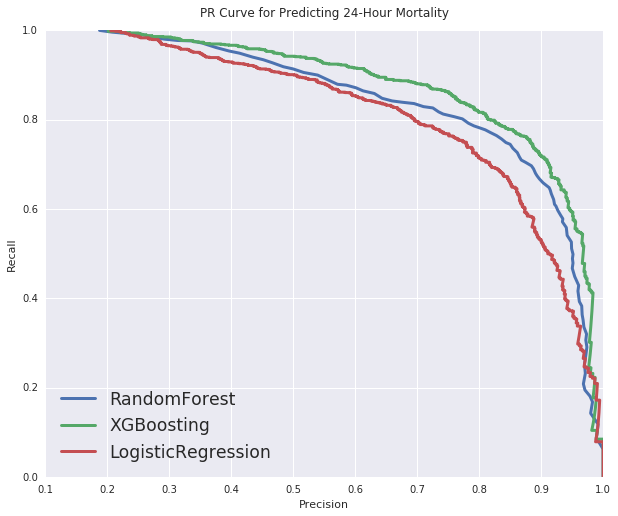

In [38]:
f, ax = plt.subplots(1, 1, figsize = (10, 8))
#f.subplots_adjust(hspace=.5)
ttl = ax.set_title('PR Curve for Predicting 24-Hour Mortality')
ttl.set_position([.5, 1.02])
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
for i, model in enumerate(models):
    #if model['name'] == 'XGBoosting':
            #ax.plot(model['pr_ALL'][0],model['pr_ALL'][1], linewidth = 3, label = model['name'])
    ax.plot(model['pr'][0],model['pr'][1], linewidth = 3, label = model['name'])
ax.legend(loc = 3, fontsize = 'x-large')    

    

## XGB Importances and Confusion Matrix

In [92]:
len(y_test)

5430

In [93]:
models[1]['confusion_matrix'] = confusion_matrix(y_test, models[1]['y_pred'])

In [94]:
models[1]['confusion_matrix']

array([[4285,  106],
       [ 281,  758]])

In [97]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(['Died', 'Survived']))
    plt.xticks(tick_marks, ['Survived', 'Died'], rotation=45)
    plt.yticks(tick_marks, ['Survived', 'Died'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
Normalized confusion matrix
[[ 0.98  0.02]
 [ 0.27  0.73]]


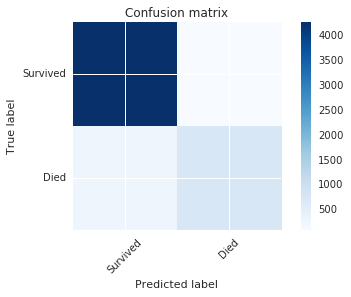

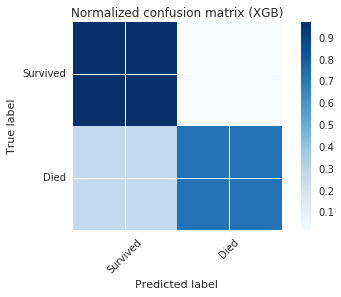

In [98]:
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(models[1]['confusion_matrix'])

cm_normalized = models[1]['confusion_matrix'].astype('float') / models[1]['confusion_matrix'].sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix (XGB)')


In [99]:
models[1]['model'].score(X_test, y_test)

0.92872928176795577

In [49]:
importances_dict = models[1]['model'].booster().get_fscore()
total = float(sum(importances_dict.values()))
total

20008.0

In [50]:
importances_dict = {k: v/total for k,v in importances_dict.items()}
xgb_importances = importances_dict.items()
xgb_importances.sort(key = lambda x: abs(x[1]), reverse = False)

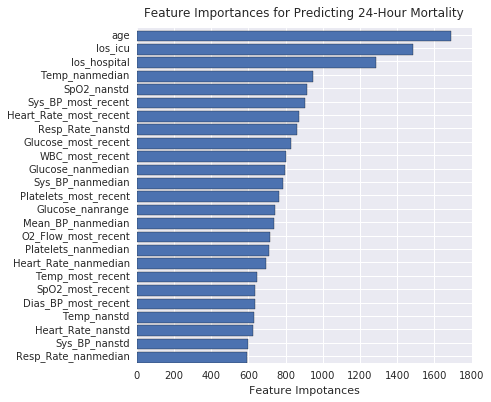

In [51]:
# plt.style.use('seaborn-pastel')
plt.figure(figsize = (6, 6))
names, imps = zip(*xgb_importances)
imps = [x*50000 for x in imps]
plt.barh(range(0, 25), imps[-25:])
plt.yticks(np.arange(0.5, 25.5), names[-25:])
ttl = plt.title("Feature Importances for Predicting 24-Hour Mortality")
plt.xlabel("Feature Impotances")
ttl.set_position([.5, 1.02])
print

In [52]:
# xgb_importances = zip(X_train.columns, models[1]['model'].feature_importances_)
# xgb_importances.sort(key = lambda x: abs(x[1]), reverse = True)
# xgb_importances

In [53]:
# f, ax = plt.subplots(figsize= (25,25))
# # plot = plt.barh()
# x = xgb.plot_importance(models[1]['model'], ax = ax)

In [55]:
# import pickle
# pickle.dump(models[1]['model'], open( "../Pickles/Models/24_XGB_model.p", "wb" ) )

## Random Forest to Get Importances

In [56]:
models[0]['model'].score(imp_X_test, y_test)

0.92430939226519337

In [57]:
rf_importances = zip(X_train.columns, models[0]['model'].feature_importances_)
rf_importances.sort(key = lambda x: abs(x[1]), reverse = True)
#rf_importances

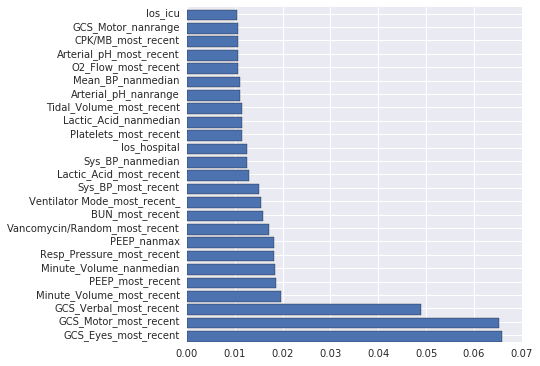

In [58]:
plt.figure(figsize = (6, 6))
names, imps = zip(*rf_importances)
plt.barh(range(0, 25), imps[0:25])
plt.yticks(np.arange(0.5, 25.5), names[0:25])
print

## Logistic Regression to get Coefficients

In [59]:
models[2]['model'].score(imp_X_test, y_test)

0.88545119705340702

In [60]:
lr_coef = zip(X_train.columns, models[2]['model'].coef_[0])
lr_coef.sort(key = lambda x: abs(x[1]), reverse = True)

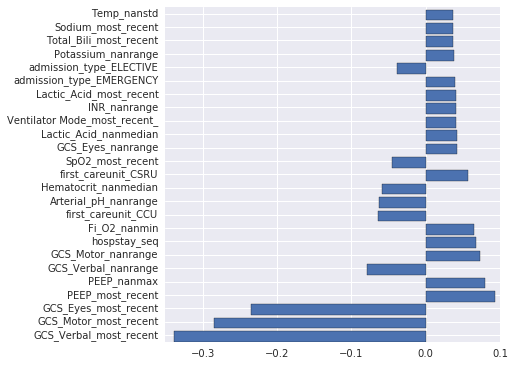

In [61]:
plt.figure(figsize = (6, 6))
names, coefs = zip(*lr_coef)
plt.barh(range(0, 25), coefs[0:25])
plt.yticks(np.arange(0.5, 25.5), names[0:25])
print

## Run XGB to predict mortality at different intervals

#### Create dictionary of different mortalities to utilize
    KEY = X hour mortality (i.e. 24, 36, etc)
    VALUE = dictionary of mappings: i.e. X_train given the train set for that particular mortality, etc
    

In [100]:
final_feature_list = ['gender',
 'los_hospital',
 'age',
 'hospstay_seq',
 'los_icu',
 'icustay_seq',
 'ethnicity_AMERICAN INDIAN/ALASKA NATIVE',
 'ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE',
 'ethnicity_ASIAN',
 'ethnicity_ASIAN - ASIAN INDIAN',
 'ethnicity_ASIAN - CAMBODIAN',
 'ethnicity_ASIAN - CHINESE',
 'ethnicity_ASIAN - FILIPINO',
 'ethnicity_ASIAN - JAPANESE',
 'ethnicity_ASIAN - KOREAN',
 'ethnicity_ASIAN - OTHER',
 'ethnicity_ASIAN - THAI',
 'ethnicity_ASIAN - VIETNAMESE',
 'ethnicity_BLACK/AFRICAN',
 'ethnicity_BLACK/AFRICAN AMERICAN',
 'ethnicity_BLACK/CAPE VERDEAN',
 'ethnicity_BLACK/HAITIAN',
 'ethnicity_CARIBBEAN ISLAND',
 'ethnicity_HISPANIC OR LATINO',
 'ethnicity_HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)',
 'ethnicity_HISPANIC/LATINO - COLOMBIAN',
 'ethnicity_HISPANIC/LATINO - CUBAN',
 'ethnicity_HISPANIC/LATINO - DOMINICAN',
 'ethnicity_HISPANIC/LATINO - GUATEMALAN',
 'ethnicity_HISPANIC/LATINO - HONDURAN',
 'ethnicity_HISPANIC/LATINO - MEXICAN',
 'ethnicity_HISPANIC/LATINO - PUERTO RICAN',
 'ethnicity_HISPANIC/LATINO - SALVADORAN',
 'ethnicity_MIDDLE EASTERN',
 'ethnicity_MULTI RACE ETHNICITY',
 'ethnicity_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
 'ethnicity_OTHER',
 'ethnicity_PATIENT DECLINED TO ANSWER',
 'ethnicity_PORTUGUESE',
 'ethnicity_SOUTH AMERICAN',
 'ethnicity_UNABLE TO OBTAIN',
 'ethnicity_UNKNOWN/NOT SPECIFIED',
 'ethnicity_WHITE',
 'ethnicity_WHITE - BRAZILIAN',
 'ethnicity_WHITE - EASTERN EUROPEAN',
 'ethnicity_WHITE - OTHER EUROPEAN',
 'ethnicity_WHITE - RUSSIAN',
 'admission_type_ELECTIVE',
 'admission_type_EMERGENCY',
 'admission_type_URGENT',
 'Sys_BP_most_recent',
 'Sys_BP_nanmedian',
 'Sys_BP_nanstd',
 'Sys_BP_nanrange',
 'PEEP_most_recent',
 'PEEP_nanmax',
 'BSA_most_recent',
 'CVP_most_recent',
 'CVP_nanmax',
 'Cardiac Index_most_recent',
 'Cuff_Pressure_most_recent',
 'ETT_most_recent',
 'GCS_Eyes_most_recent',
 'GCS_Eyes_nanrange',
 'Heart_Rate_most_recent',
 'Heart_Rate_nanmedian',
 'Heart_Rate_nanstd',
 'Heart_Rate_nanrange',
 'Resp_Pressure_most_recent',
 'Minute_Volume_most_recent',
 'Minute_Volume_nanmedian',
 'GCS_Motor_most_recent',
 'GCS_Motor_nanrange',
 'Mean_BP_most_recent',
 'Mean_BP_nanmedian',
 'Mean_BP_nanstd',
 'Mean_BP_nanrange',
 'O2_Flow_most_recent',
 'PAP Systolic_most_recent',
 'PCWP_most_recent',
 'Plateau_Pressure_most_recent',
 'Pressure_Support_most_recent',
 'Resp_Rate_most_recent',
 'Resp_Rate_nanmedian',
 'Resp_Rate_nanstd',
 'Resp_Rate_nanrange',
 'SVR_most_recent',
 'Tidal_Volume_most_recent',
 'SpO2_most_recent',
 'SpO2_nanmedian',
 'SpO2_nanstd',
 'SpO2_nanrange',
 'GCS_Verbal_most_recent',
 'GCS_Verbal_nanrange',
 'Waveform-Vent_most_recent',
 'Admit Wt_most_recent',
 'ALT_most_recent',
 'ALT_nanmedian',
 'ALT_nanrange',
 'AST_most_recent',
 'AST_nanmedian',
 'AST_nanrange',
 'Alkaline_Phosphate_most_recent',
 'Alkaline_Phosphate_nanmedian',
 'Alkaline_Phosphate_nanrange',
 'Arterial CO2(Calc)_most_recent',
 'Arterial PaCO2_most_recent',
 'Arterial PaO2_most_recent',
 'Arterial_pH_most_recent',
 'Arterial_pH_nanmin',
 'Arterial_pH_nanmedian',
 'Arterial_pH_nanrange',
 'Bicarbonate_most_recent',
 'Bicarbonate_nanmedian',
 'Bicarbonate_nanrange',
 'D-Dimer (0-500)_most_recent',
 'Fibrinogen (150-400)_most_recent',
 'Glucose_most_recent',
 'Glucose_nanmedian',
 'Glucose_nanrange',
 'Hematocrit_most_recent',
 'Hematocrit_nanmedian',
 'Hematocrit_nanrange',
 'Hemoglobin_most_recent',
 'Hemoglobin_nanmedian',
 'Hemoglobin_nanrange',
 'LDH_most_recent',
 'LDH_nanmedian',
 'LDH_nanrange',
 'RBC_most_recent',
 'RBC_nanmedian',
 'RBC_nanrange',
 'SaO2_most_recent',
 'SaO2_nanmedian',
 'SaO2_nanstd',
 'SaO2_nanrange',
 'Troponin_most_recent',
 'Troponin_nanmedian',
 'Troponin_nanrange',
 'Vancomycin/Random_most_recent',
 'BUN_most_recent',
 'BUN_nanmedian',
 'BUN_nanrange',
 'Albumin_most_recent',
 'Albumin_nanmedian',
 'Albumin_nanrange',
 'Calcium_most_recent',
 'Calcium_nanmedian',
 'Calcium_nanrange',
 'Chloride_most_recent',
 'Chloride_nanmedian',
 'Chloride_nanrange',
 'Creatinine_most_recent',
 'Creatinine_nanmedian',
 'Creatinine_nanrange',
 'INR_most_recent',
 'INR_nanmedian',
 'INR_nanrange',
 'Lactic_Acid_most_recent',
 'Lactic_Acid_nanmedian',
 'Lactic_Acid_nanmax',
 'Lactic_Acid_nanrange',
 'Magnesium_most_recent',
 'Magnesium_nanmedian',
 'Magnesium_nanrange',
 'Phosphorous_most_recent',
 'Phosphorous_nanmedian',
 'Phosphorous_nanrange',
 'Potassium_most_recent',
 'Potassium_nanmedian',
 'Potassium_nanrange',
 'Total_Bili_most_recent',
 'Total_Bili_nanmedian',
 'Total_Bili_nanrange',
 'WBC_most_recent',
 'WBC_nanmedian',
 'WBC_nanrange',
 'APRV_Pressure_most_recent',
 'Dias_BP_most_recent',
 'Dias_BP_nanmedian',
 'Dias_BP_nanstd',
 'Dias_BP_nanrange',
 'PAP Diastolic_most_recent',
 'Central Venous Pressure_most_recent',
 'Arterial O2 pressure_most_recent',
 'Arterial O2 Saturation_most_recent',
 'Arterial CO2 Pressure_most_recent',
 'Temp_most_recent',
 'Temp_nanmedian',
 'Temp_nanstd',
 'Temp_nanrange',
 'Fi_O2_most_recent',
 'Fi_O2_nanmin',
 'PSV_level_most_recent',
 'CK_most_recent',
 'TCO2 (calc) Arterial_most_recent',
 'Sodium_most_recent',
 'Sodium_nanmedian',
 'Sodium_nanrange',
 'Anion gap_most_recent',
 'CPK/MB_most_recent',
 'Platelets_most_recent',
 'Platelets_nanmedian',
 'Platelets_nanrange',
 'Fibrinogen_most_recent',
 'Fibrinogen_nanmedian',
 u'Heart Rhythm_most_recent_1st Deg AV Block',
 u'Heart Rhythm_most_recent_2nd AVB/Mobitz I',
 u'Heart Rhythm_most_recent_A Paced',
 u'Heart Rhythm_most_recent_AV Paced',
 u'Heart Rhythm_most_recent_Atrial Fib',
 u'Heart Rhythm_most_recent_Atrial Flutter',
 u'Heart Rhythm_most_recent_Junctional',
 u'Heart Rhythm_most_recent_Normal Sinus',
 u'Heart Rhythm_most_recent_Other/Remarks',
 u'Heart Rhythm_most_recent_Sinus Arrhythmia',
 u'Heart Rhythm_most_recent_Sinus Brady',
 u'Heart Rhythm_most_recent_Sinus Tachy',
 u'Heart Rhythm_most_recent_V Paced',
 u'O2_From_Ventilator_most_recent_',
 u'O2_From_Ventilator_most_recent_Aerosol-Cool',
 u'O2_From_Ventilator_most_recent_Bipap Mask',
 u'O2_From_Ventilator_most_recent_Face Tent',
 u'O2_From_Ventilator_most_recent_Hi Flow Neb',
 u'O2_From_Ventilator_most_recent_Nasal Cannula',
 u'O2_From_Ventilator_most_recent_Non-Rebreather',
 u'O2_From_Ventilator_most_recent_None',
 u'O2_From_Ventilator_most_recent_Other/Remarks',
 u'O2_From_Ventilator_most_recent_T-Piece',
 u'O2_From_Ventilator_most_recent_Trach Mask',
 u'O2_From_Ventilator_most_recent_Venti Mask',
 u'Ventilator Mode_most_recent_',
 u'Ventilator Mode_most_recent_Assist Control',
 u'Ventilator Mode_most_recent_CMV',
 u'Ventilator Mode_most_recent_CPAP',
 u'Ventilator Mode_most_recent_CPAP+PS',
 u'Ventilator Mode_most_recent_Other/Remarks',
 u'Ventilator Mode_most_recent_Pressure Control',
 u'Ventilator Mode_most_recent_Pressure Support',
 u'Ventilator Mode_most_recent_SIMV',
 u'Ventilator Mode_most_recent_SIMV+PS',
 u'Ventilator Mode_most_recent_TCPCV',
 u'Marital Status_most_recent_',
 u'Marital Status_most_recent_A',
 u'Marital Status_most_recent_D',
 u'Marital Status_most_recent_M',
 u'Marital Status_most_recent_S',
 u'Marital Status_most_recent_W',
 u'Religion_most_recent_',
 u'Religion_most_recent_JEW',
 u'Religion_most_recent_NSP',
 u'Religion_most_recent_OTR',
 u'Religion_most_recent_PRO',
 u'Religion_most_recent_RCA',
 u'Religion_most_recent_U',
 u'Pain Present_most_recent_',
 u'Pain Present_most_recent_No',
 u'Pain Present_most_recent_Other/Remarks',
 u'Pain Present_most_recent_Yes',
 u'first_careunit_CCU',
 u'first_careunit_CSRU',
 u'first_careunit_MICU',
 u'first_careunit_SICU',
 u'first_careunit_TSICU',
 u'hospital_expire_flag',
 u'icustay_id']

In [109]:
hours_dict = {}
hours_dict_on_24 = {}
hours_out_list = [24, 36, 48, 60, 72, 168, 336]
for hours_out in hours_out_list:
    
    #Read in all dataframes 
    model_transformed_df = pd.read_pickle('../Pickles/' + str(hours_out) + '_out_model_df.p')
    
    #Switch one hot encoded Service Type with admission care unit
    service_cols = [col for col in model_transformed_df.columns if 'Service Type' in col]
    model_transformed_df = model_transformed_df.drop(service_cols, axis = 1)
    services_df = pd.read_pickle("../Pickles/services.p")
    model_transformed_df = model_transformed_df.merge(services_df , on = 'icustay_id')

    #One hot encode first care unit
    model_transformed_df = pd.get_dummies(model_transformed_df, columns = ['first_careunit'])
    
    #Drop things like intime discharge time etc for model
    modelable_df = model_transformed_df.drop(list(typefeature_dict[5]), axis = 1)
    
    #change names that are troublesome for pandas
    model_column_names = list(modelable_df.columns)
    model_column_names = [x.replace('<', "_LESS_") for x in model_column_names]
    model_column_names = [x.replace('[', "") for x in model_column_names]
    model_column_names = [x.replace(']', "") for x in model_column_names]
    modelable_df.columns = model_column_names
    modelable_df = modelable_df[final_feature_list]
    
    X = modelable_df.drop(['hospital_expire_flag'], axis = 1)
    X.los_icu = X.los_icu - float(hours_out)/24
    X.los_hospital = X.los_hospital - float(hours_out)/24
    
    y = modelable_df['hospital_expire_flag']
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                   test_size = 0.30)
    
    X_test = X_test.drop(['icustay_id'], axis = 1)
    X_train = X_train.drop(['icustay_id'], axis = 1)
    X = X.drop(['icustay_id'], axis = 1)

    
    cur_hour_dict = {}
    cur_hour_dict['X_train'] = X_train
    cur_hour_dict['X_test'] = X_test
    cur_hour_dict['X'] = X
    
    cur_hour_dict['y_train'] = y_train
    cur_hour_dict['y_test'] = y_test
    cur_hour_dict['y'] = y
    
    cur_hour_dict['name'] = str(round(float(hours_out/24),1)) + "-day mortality"
    hours_dict_on_24[hours_out] = cur_hour_dict
    hours_dict[hours_out] = cur_hour_dict.copy()

In [110]:
print len(hours_dict_on_24[24]['X_train'].columns)

264


In [111]:
for t in hours_out_list:
    print len(hours_dict_on_24[t]['X'])

18097
17776
15531
12943
11265
4924
1973


#### Create XGB classifier

In [112]:
import xgboost

In [113]:
xgb = xgboost.XGBClassifier(max_depth = 5,
#                                                         n_estimators = 100,
                                                        n_estimators = 1000, 
                                                         learning_rate = 0.05,                                                    
#                                                        learning_rate = 0.10, 
                                                        min_child_weight = 1, 
                                                        silent = False)
xgb_on_24 = xgboost.XGBClassifier(max_depth = 5,
#                                                         n_estimators = 100,
                                                        n_estimators = 1000, 
                                                         learning_rate = 0.05,                                                    
#                                                        learning_rate = 0.10, 
                                                        min_child_weight = 1, 
                                                        silent = False)

#### Run same XGB Classifier on all dataframes (predicting 24, 36, etc. hr mortality)

In [114]:
list_to_plot = [24, 48, 72, 168, 336]

TRAIN/TEST RAN ON SAME:
For the 1.0-day mortality model: 
The accuracy is: 0.9333
The precision is: 0.8834
The recall is: 0.7404
The f1 score is: 0.8056

ALL TEST RAN ON 24-HR MORTALITY MODEL:
For the 1.0-day mortality model: 
The accuracy is: 0.9783
The precision is: 0.9691
The recall is: 0.9145
The f1 score is: 0.9410



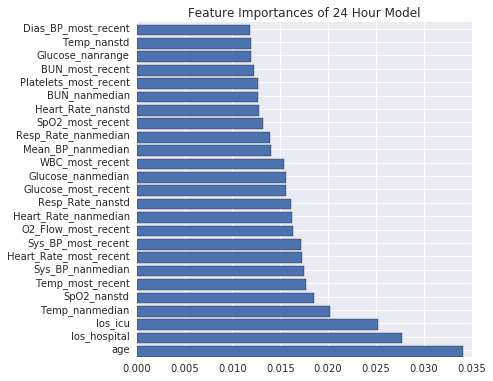

Normalized confusion matrix on 24 Hour Model
[[ 0.98  0.02]
 [ 0.26  0.74]]


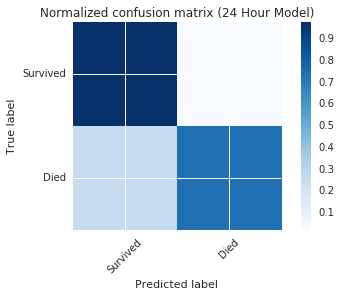

Normalized confusion matrix - on 24 Hour Model (24 Hours Prediction)
[[ 0.99  0.01]
 [ 0.09  0.91]]


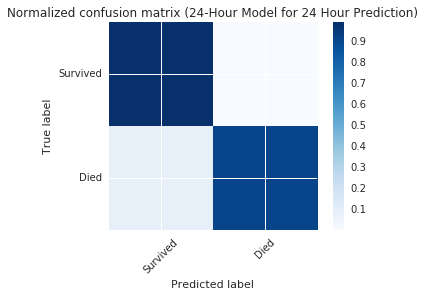

TRAIN/TEST RAN ON SAME:
For the 2.0-day mortality model: 
The accuracy is: 0.9021
The precision is: 0.8249
The recall is: 0.6376
The f1 score is: 0.7192

ALL TEST RAN ON 24-HR MORTALITY MODEL:
For the 2.0-day mortality model: 
The accuracy is: 0.9077
The precision is: 0.7928
The recall is: 0.7233
The f1 score is: 0.7565



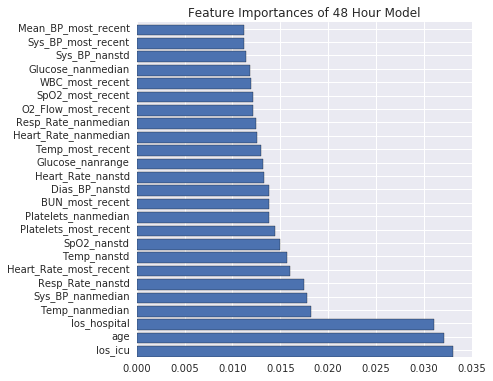

Normalized confusion matrix on 48 Hour Model
[[ 0.97  0.03]
 [ 0.36  0.64]]


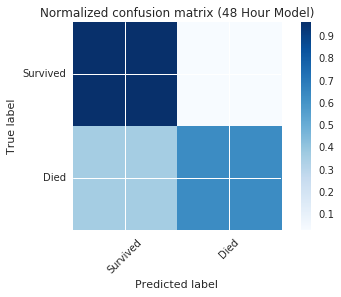

Normalized confusion matrix - on 24 Hour Model (48 Hours Prediction)
[[ 0.95  0.05]
 [ 0.28  0.72]]


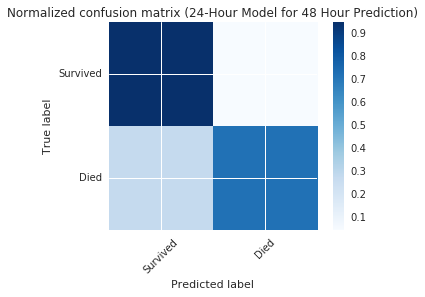

TRAIN/TEST RAN ON SAME:
For the 3.0-day mortality model: 
The accuracy is: 0.8790
The precision is: 0.7997
The recall is: 0.6181
The f1 score is: 0.6973

ALL TEST RAN ON 24-HR MORTALITY MODEL:
For the 3.0-day mortality model: 
The accuracy is: 0.8594
The precision is: 0.6949
The recall is: 0.6933
The f1 score is: 0.6941



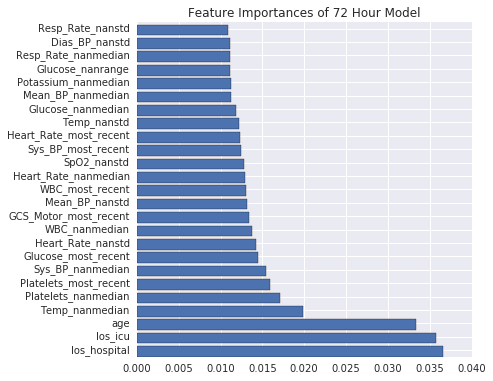

Normalized confusion matrix on 72 Hour Model
[[ 0.95  0.05]
 [ 0.38  0.62]]


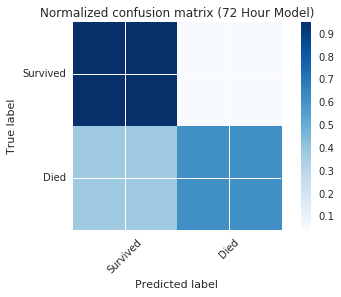

Normalized confusion matrix - on 24 Hour Model (72 Hours Prediction)
[[ 0.91  0.09]
 [ 0.31  0.69]]


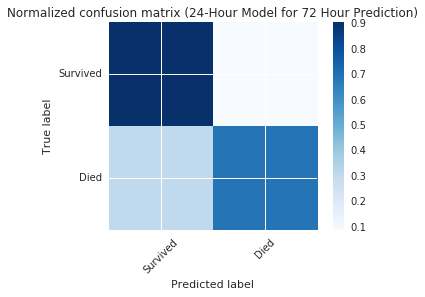

TRAIN/TEST RAN ON SAME:
For the 7.0-day mortality model: 
The accuracy is: 0.8092
The precision is: 0.7175
The recall is: 0.5312
The f1 score is: 0.6105

ALL TEST RAN ON 24-HR MORTALITY MODEL:
For the 7.0-day mortality model: 
The accuracy is: 0.7281
The precision is: 0.5074
The recall is: 0.7001
The f1 score is: 0.5884



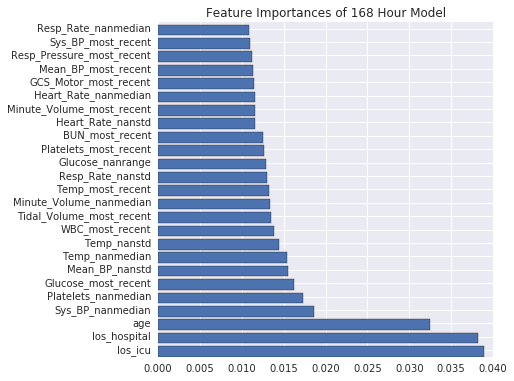

Normalized confusion matrix on 168 Hour Model
[[ 0.92  0.08]
 [ 0.47  0.53]]


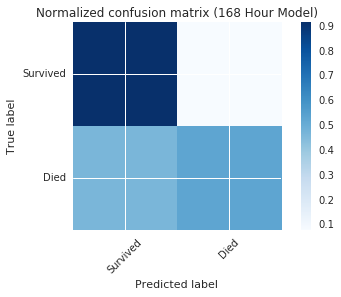

Normalized confusion matrix - on 24 Hour Model (168 Hours Prediction)
[[ 0.74  0.26]
 [ 0.3   0.7 ]]


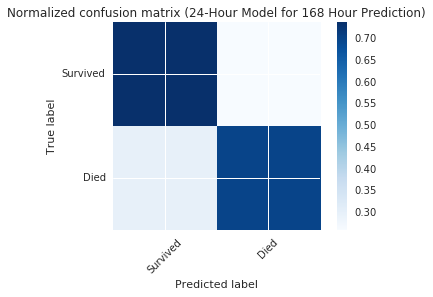

TRAIN/TEST RAN ON SAME:
For the 14.0-day mortality model: 
The accuracy is: 0.7500
The precision is: 0.6833
The recall is: 0.4271
The f1 score is: 0.5256

ALL TEST RAN ON 24-HR MORTALITY MODEL:
For the 14.0-day mortality model: 
The accuracy is: 0.6092
The precision is: 0.4078
The recall is: 0.6934
The f1 score is: 0.5136



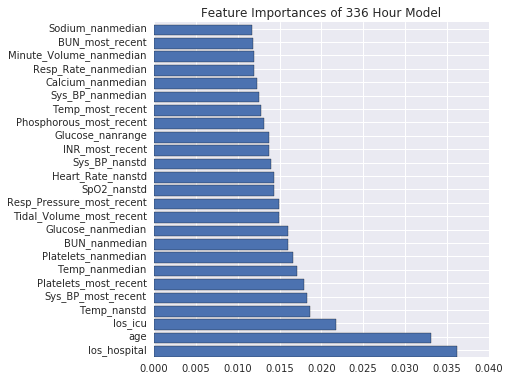

Normalized confusion matrix on 336 Hour Model
[[ 0.91  0.1 ]
 [ 0.57  0.43]]


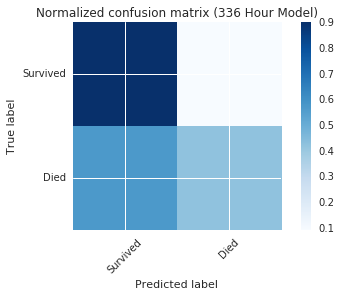

Normalized confusion matrix - on 24 Hour Model (336 Hours Prediction)
[[ 0.57  0.43]
 [ 0.31  0.69]]


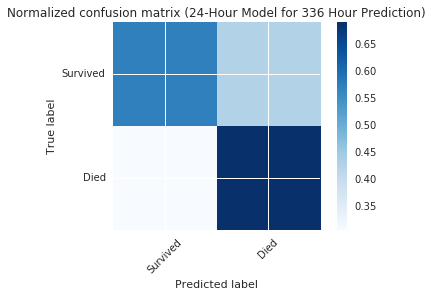

In [116]:
xgb_on_24.fit(hours_dict_on_24[24]['X_train'], hours_dict_on_24[24]['y_train'])

for hours_out in list_to_plot:
    
    # RUN ALL MODELS ON CORRESPONDING MODEL so same test and train (i.e. 24 on 24, 48 on 48)
    xgb.fit(hours_dict[hours_out]['X_train'], hours_dict[hours_out]['y_train'])
    hours_dict[hours_out]['y_pred'] = xgb.predict(hours_dict[hours_out]['X_test'])
    hours_dict[hours_out]['y_proba'] = xgb.predict_proba(hours_dict[hours_out]['X_test'])[:, 1]
    hours_dict[hours_out]['accuracy'] = accuracy_score(hours_dict[hours_out]['y_test'], hours_dict[hours_out]['y_pred'])
    hours_dict[hours_out]['precision'] = precision_score(hours_dict[hours_out]['y_test'], hours_dict[hours_out]['y_pred'])
    hours_dict[hours_out]['recall'] = recall_score(hours_dict[hours_out]['y_test'], hours_dict[hours_out]['y_pred'])
    hours_dict[hours_out]['f1'] = f1_score(hours_dict[hours_out]['y_test'], hours_dict[hours_out]['y_pred'])
    hours_dict[hours_out]['confusion_matrix'] = confusion_matrix(hours_dict[hours_out]['y_test'], hours_dict[hours_out]['y_pred'])
    
    
    # RUN ALL MODELS ON 24-HR MODEL so train on 24 and test on all other intervals
    hours_dict_on_24[hours_out]['y_pred'] = xgb_on_24.predict(hours_dict_on_24[hours_out]['X'])
    hours_dict_on_24[hours_out]['y_proba'] = xgb_on_24.predict_proba(hours_dict_on_24[hours_out]['X'])[:, 1]
    hours_dict_on_24[hours_out]['accuracy'] = accuracy_score(hours_dict_on_24[hours_out]['y'], hours_dict_on_24[hours_out]['y_pred'])
    hours_dict_on_24[hours_out]['precision'] = precision_score(hours_dict_on_24[hours_out]['y'], hours_dict_on_24[hours_out]['y_pred'])
    hours_dict_on_24[hours_out]['recall'] = recall_score(hours_dict_on_24[hours_out]['y'], hours_dict_on_24[hours_out]['y_pred'])
    hours_dict_on_24[hours_out]['f1'] = f1_score(hours_dict_on_24[hours_out]['y'], hours_dict_on_24[hours_out]['y_pred'])
    hours_dict_on_24[hours_out]['confusion_matrix'] = confusion_matrix(hours_dict_on_24[hours_out]['y'], hours_dict_on_24[hours_out]['y_pred'])
    
    
    print "TRAIN/TEST RAN ON SAME:"
    print "For the %s model: " %hours_dict[hours_out]['name']
    print "The accuracy is: %0.4f" %hours_dict[hours_out]['accuracy']
    print "The precision is: %0.4f" %hours_dict[hours_out]['precision']
    print "The recall is: %0.4f" %hours_dict[hours_out]['recall']
    print "The f1 score is: %0.4f" %hours_dict[hours_out]['f1']
    print
    
    print "ALL TEST RAN ON 24-HR MORTALITY MODEL:"
    print "For the %s model: " %hours_dict_on_24[hours_out]['name']
    print "The accuracy is: %0.4f" %hours_dict_on_24[hours_out]['accuracy']
    print "The precision is: %0.4f" %hours_dict_on_24[hours_out]['precision']
    print "The recall is: %0.4f" %hours_dict_on_24[hours_out]['recall']
    print "The f1 score is: %0.4f" %hours_dict_on_24[hours_out]['f1']
    print
    
    importances_dict = xgb.booster().get_fscore()
    total = float(sum(importances_dict.values()))
    importances_dict = {k: v/total for k,v in importances_dict.items()}
    xgb_importances = importances_dict.items()
    xgb_importances.sort(key = lambda x: abs(x[1]), reverse = True)
    plt.figure(figsize = (6, 6))
    names, imps = zip(*xgb_importances)
    plt.title('Feature Importances of %s Hour Model' %hours_out)
    plt.barh(range(0, 25), imps[0:25])
    plt.yticks(np.arange(0.5, 25.5), names[0:25])
    plt.show()
    
    cm_normalized = hours_dict[hours_out]['confusion_matrix'].astype('float') / hours_dict[hours_out]['confusion_matrix'].sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix on %d Hour Model' %hours_out)
    print(cm_normalized)
    plt.figure()
    plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix (%d Hour Model)' %hours_out)
    plt.show()
    
    cm_normalized = hours_dict_on_24[hours_out]['confusion_matrix'].astype('float') / hours_dict_on_24[hours_out]['confusion_matrix'].sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix - on 24 Hour Model (%d Hours Prediction)' %hours_out)   
    print(cm_normalized)
    plt.figure()
    plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix (24-Hour Model for %d Hour Prediction)' %hours_out)
    plt.show()
    
    

The AUC for 1.0-day mortality is 0.9563
The AUC for 2.0-day mortality is 0.9277
The AUC for 3.0-day mortality is 0.9090
The AUC for 7.0-day mortality is 0.8477
The AUC for 14.0-day mortality is 0.7747
The AUC for 2.0-day mortality is 0.9414
The AUC for 3.0-day mortality is 0.9041
The AUC for 7.0-day mortality is 0.8027
The AUC for 14.0-day mortality is 0.6996


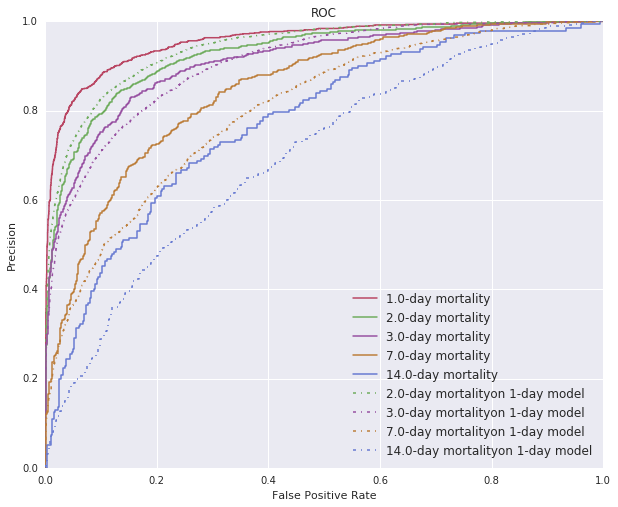

In [117]:
f, ax = plt.subplots(1, 1, figsize = (10, 8))
#f.subplots_adjust(hspace=.5)
ax.set_title('ROC')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('Precision')
colors = ["#b94663",
"#6fac5d",
"#9750a1",
"#bc7d39",
"#677ad1"]
i = 0
for hours_out in list_to_plot:
    hours_dict[hours_out]['auc'] = roc_auc_score(hours_dict[hours_out]['y_test'], hours_dict[hours_out]['y_proba'])
    hours_dict[hours_out]['roc'] = roc_curve(hours_dict[hours_out]['y_test'], hours_dict[hours_out]['y_proba'])
    ax.plot(hours_dict[hours_out]['roc'][0],hours_dict[hours_out]['roc'][1], c = colors[i], linewidth = 1.5, label = hours_dict[hours_out]['name']) 
    print "The AUC for %s is %0.4f" %(hours_dict[hours_out]['name'], hours_dict[hours_out]['auc'])
    i+= 1

i = 0
for hours_out in list_to_plot:
    if hours_out != 24:
        hours_dict_on_24[hours_out]['auc'] = roc_auc_score(hours_dict_on_24[hours_out]['y'], hours_dict_on_24[hours_out]['y_proba'])
        hours_dict_on_24[hours_out]['roc'] = roc_curve(hours_dict_on_24[hours_out]['y'], hours_dict_on_24[hours_out]['y_proba'])
        label_24 = hours_dict_on_24[hours_out]['name'] + "on 1-day model"
        ax.plot(hours_dict_on_24[hours_out]['roc'][0],hours_dict_on_24[hours_out]['roc'][1], '-.', c = colors[i], linewidth = 1.5, label = label_24) 
        print "The AUC for %s is %0.4f" %(hours_dict_on_24[hours_out]['name'], hours_dict_on_24[hours_out]['auc'])
    i += 1

ax.legend(loc = 4, fontsize = 'large')    
f.show()

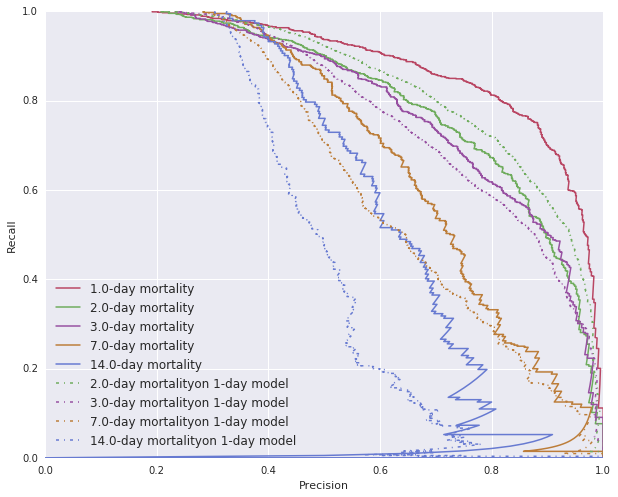

In [118]:
f, ax = plt.subplots(1, 1, figsize = (10, 8))
#f.subplots_adjust(hspace=.5)
#ax.set_title('PR Curve')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')

colors = ["#b94663",
"#6fac5d",
"#9750a1",
"#bc7d39",
"#677ad1"]
i = 0
for hours_out in list_to_plot:
    hours_dict[hours_out]['pr'] = precision_recall_curve(hours_dict[hours_out]['y_test'], hours_dict[hours_out]['y_proba'])
    ax.plot(hours_dict[hours_out]['pr'][0],hours_dict[hours_out]['pr'][1], c = colors[i], linewidth = 1.5, label = hours_dict[hours_out]['name']) 
    i+= 1

i = 0
for hours_out in list_to_plot:
    if hours_out != 24:
        hours_dict_on_24[hours_out]['pr'] = precision_recall_curve(hours_dict_on_24[hours_out]['y'], hours_dict_on_24[hours_out]['y_proba'])
        label_24 = hours_dict_on_24[hours_out]['name'] + "on 1-day model"
        ax.plot(hours_dict_on_24[hours_out]['pr'][0],hours_dict_on_24[hours_out]['pr'][1], '-.', c = colors[i], linewidth = 1.5, label = label_24) 
    i += 1

ax.legend(loc = 3, fontsize = 'large')
    

In [144]:
len(modelable_df)#[modelable_df.hospital_expire_flag == 1].loc[:,'los_icu'])

18097

(0.0, 50)

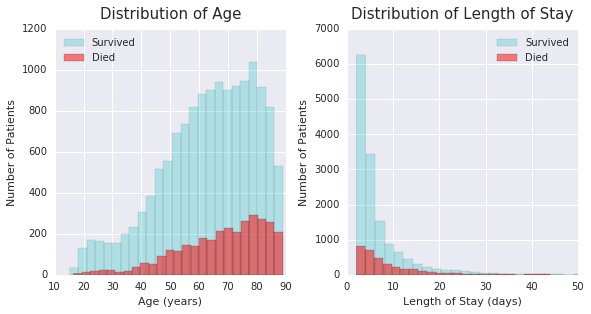

In [158]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
plt.tight_layout(h_pad=5, w_pad=3)

ax[0].hist(modelable_df[modelable_df.hospital_expire_flag == 0].loc[:,'age'].dropna(), bins=25, color='c', alpha=0.25, label='Survived')
ax[0].hist(modelable_df[modelable_df.hospital_expire_flag == 1].loc[:,'age'].dropna(), bins=25, color='r', alpha=0.5, label='Died')
ttl = ax[0].set_title('Distribution of Age', fontsize=15)
ttl.set_position([.5, 1.02])
ax[0].set_ylabel('Number of Patients')
#ax[0].set_yticks(range(0, 150, 10))
ax[0].set_xlabel('Age (years)')
ax[0].legend(loc='best')

ax[1].hist(modelable_df[modelable_df.hospital_expire_flag == 0].loc[:,'los_icu'].dropna(), bins=50, color='c', alpha=0.25, label='Survived')
ax[1].hist(modelable_df[modelable_df.hospital_expire_flag == 1].loc[:,'los_icu'].dropna(), bins=50, color='r', alpha=0.5, label='Died')
ttl = ax[1].set_title('Distribution of Length of Stay', fontsize=15)
ttl.set_position([.5, 1.02])
ax[1].set_ylabel('Number of Patients')
#ax[1].set_yticks(range(0, 150, 10))
#ax[1].set_xticks(range(0, 100, 5))
ax[1].set_xlabel('Length of Stay (days)')
ax[1].legend(loc='best')
ax[1].set_xlim(xmax = 50)


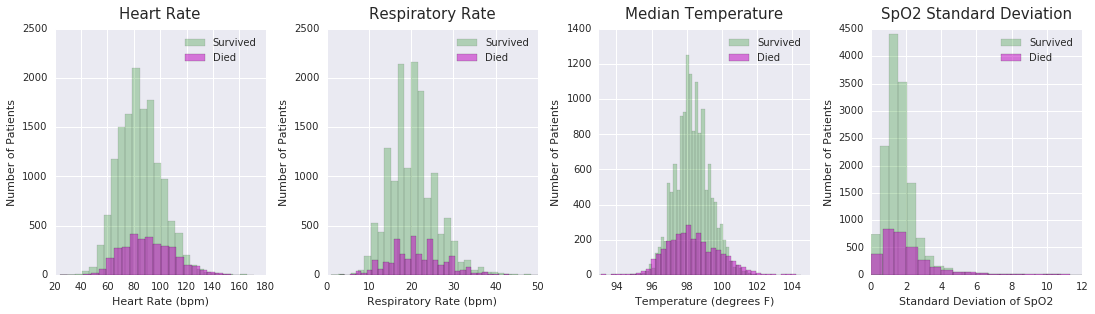

In [163]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 4))
plt.tight_layout(h_pad=5, w_pad=3)

ax[0].hist(modelable_df[modelable_df.hospital_expire_flag == 0].loc[:,'Heart_Rate_most_recent'].dropna(), bins=25, color='g', alpha=0.25, label='Survived')
ax[0].hist(modelable_df[modelable_df.hospital_expire_flag == 1].loc[:,'Heart_Rate_most_recent'].dropna(), bins=25, color='m', alpha=0.5, label='Died')
ttl = ax[0].set_title('Heart Rate', fontsize=15)
ttl.set_position([.5, 1.02])
ax[0].set_ylabel('Number of Patients')
#ax[0].set_yticks(range(0, 150, 10))
ax[0].set_xlabel('Heart Rate (bpm)')
ax[0].legend(loc='best')

ax[1].hist(modelable_df[modelable_df.hospital_expire_flag == 0].loc[:,'Resp_Rate_most_recent'].dropna(), bins=50, color='g', alpha=0.25, label='Survived')
ax[1].hist(modelable_df[modelable_df.hospital_expire_flag == 1].loc[:,'Resp_Rate_most_recent'].dropna(), bins=50, color='m', alpha=0.5, label='Died')
ttl = ax[1].set_title('Respiratory Rate', fontsize=15)
ttl.set_position([.5, 1.02])
ax[1].set_ylabel('Number of Patients')
#ax[1].set_yticks(range(0, 150, 10))
#ax[1].set_xticks(range(0, 100, 5))
ax[1].set_xlim(xmax = 50)
ax[1].set_xlabel('Respiratory Rate (bpm)')
ax[1].legend(loc='best')


ax[2].hist(modelable_df[modelable_df.hospital_expire_flag == 0].loc[:,'Temp_nanmedian'].dropna(), bins=50, color='g', alpha=0.25, label='Survived')
ax[2].hist(modelable_df[modelable_df.hospital_expire_flag == 1].loc[:,'Temp_nanmedian'].dropna(), bins=50, color='m', alpha=0.5, label='Died')
ttl = ax[2].set_title('Median Temperature', fontsize=15)
ttl.set_position([.5, 1.02])
ax[2].set_ylabel('Number of Patients')
#ax[1].set_yticks(range(0, 150, 10))
#ax[1].set_xticks(range(0, 100, 5))
ax[2].set_xlim((93,105))
ax[2].set_xlabel('Temperature (degrees F)')
ax[2].legend(loc='best')


ax[3].hist(modelable_df[modelable_df.hospital_expire_flag == 0].loc[:,'SpO2_nanstd'].dropna(), bins=50, color='g', alpha=0.25, label='Survived')
ax[3].hist(modelable_df[modelable_df.hospital_expire_flag == 1].loc[:,'SpO2_nanstd'].dropna(), bins=50, color='m', alpha=0.5, label='Died')
ttl = ax[3].set_title('SpO2 Standard Deviation', fontsize=15)
ttl.set_position([.5, 1.02])
ax[3].set_ylabel('Number of Patients')
#ax[1].set_yticks(range(0, 150, 10))
#ax[1].set_xticks(range(0, 100, 5))
ax[3].set_xlim(xmax = 12)
ax[3].set_xlabel('Standard Deviation of SpO2')
ax[3].legend(loc='best')